# Welcome to FI6024 E-tivity 1
The aims of this activity are the following: 

A) To apply simple and advanced portfolio optimization methods on a small stock universe.

B) To create a factor model of asset returns using linear regression

#### Your tasks are:

1) Enter your name and UL Student ID in the next section.

2) Run the remainder of the code, taking your time to understand each cell. 

3) Complete Tasks 1-xx where the sections of code are highlighted with #TODO.

#### Student Information:
Your Name: Zheng Hanming

Your Student ID Number: 21225621

### Install Libraries

In [53]:
# pip install -U setuptools --user

In [54]:
# pip install SQLAlchemy numpy pandas scipy cvxpy scikit-learn --user

### Imports

In [55]:
import numpy as np
import pandas as pd
import cvxpy as cvx
import matplotlib.pyplot as plt
import yfinance as yf

## Section A) Data Import

### Task 1 
Use [yfinance](https://pypi.org/project/yfinance/) or otherwise to download daily adjusted close prices for tickers Apple Inc. (AAPL), International Business Machines Corporation (IBM)​, and the SPDR S&P 500 Trust ETF (SPY) between Jul 01, 2013 and Jun 29, 2017.


The [SPDR S&P 500 trust](https://en.wikipedia.org/wiki/SPDR_S%26P_500_Trust_ETF) is an exchange-traded fund which trades on the NYSE Arca under the symbol. SPDR is an acronym for the Standard & Poor's Depositary Receipts, the former name of the ETF. It is designed to track the S&P 500 stock market index. This fund is the largest ETF in the world.

Call your final Price Dataframe, ``price_df``.

### Hint: If using yfinance
``yfinance`` returns a pandas.DataFrame with multi-level column names, with a level for the ticker and a level for the stock price data.

The Option 2 answer on Stack Overflow is helpful for this:[How to deal with multi-level column names downloaded with yfinance?](https://stackoverflow.com/questions/63107594/how-to-deal-with-multi-level-column-names-downloaded-with-yfinance/63107801#63107801)

e.g.

``df = df.stack(level=1).rename_axis(['Date', 'Ticker']).reset_index(level=1)
price_df = df.pivot(columns='Ticker', values='Adj Close')``

In [56]:
# Download daily adjusted close prices for tickers Apple Inc. (AAPL), International Business Machines Corporation (IBM), 
# and the SPDR S&P 500 Trust ETF (SPY) between Jul 01, 2013 and Jun 29, 2017
tickers = ['AAPL', 'IBM', 'SPY']
df = yf.download(tickers, group_by='Ticker', start='2013-07-01', end='2017-06-29')
df = df.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)
price_df = df.pivot(columns='Ticker', values='Adj Close')
price_df

[*********************100%***********************]  3 of 3 completed


Ticker           AAPL         IBM         SPY
Date                                         
2013-07-01  12.725652  124.855133  135.945053
2013-07-02  13.013927  124.998764  135.818756
2013-07-03  13.085757  126.140976  135.877747
2013-07-05  12.980652  127.237633  137.343613
2013-07-08  12.906949  127.270195  138.127136
...               ...         ...         ...
2017-06-22  34.360939  113.797775  221.743759
2017-06-23  34.514301  113.584061  222.008591
2017-06-26  34.405769  114.409485  222.154694
2017-06-27  33.912643  114.055725  220.364944
2017-06-28  34.408134  114.475838  222.337311

[1007 rows x 3 columns]

## Section B) Generate Covariance Matrix of Ticker Returns

### Key Inputs:

#### standard deviation
standard deviation $\sigma_A = \sqrt(\sigma^2_A)$, where $\sigma^2_A$ is variance of $x_A$
look at `np.sqrt()`

#### covariance
correlation between the stocks is $\rho_{A,B}$

covariance between the stocks is $\sigma_{A,B} = \sigma_A \times \sigma_B \times \rho_{A,B}$

#### covariance matrix
The covariance matrix $P = 
\begin{bmatrix}
\sigma^2_A & \sigma_{A,B} \\ 
\sigma_{A,B} & \sigma^2_B 
\end{bmatrix}$

We can create a 2 x 2 matrix using a 2-dimensional numpy array
`np.array([["Cindy", "Liz"],["Eddy", "Brok"]])`

#### [numpy.cov](https://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html)

If we have $m$ stock series, the covariance matrix is an $m \times m$ matrix containing the covariance between each pair of stocks.  We can use [numpy.cov](https://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html) to get the covariance.  We give it a 2D array in which each row is a stock series, and each column is an observation at the same period of time. For any `NaN` values, you can replace them with zeros using the [`DataFrame.fillna`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) function.

The covariance matrix $\mathbf{P} = 
\begin{bmatrix}
\sigma^2_{1,1} & ... & \sigma^2_{1,m} \\ 
... & ... & ...\\
\sigma_{m,1} & ... & \sigma^2_{m,m}  \\
\end{bmatrix}$


### Task 2

Calculate Log Returns using the formula $ ln(\frac{p_{t}}{p_{t-1}}) $. using the [`np.log`](https://numpy.org/doc/stable/reference/generated/numpy.log.html) function. Then, use use [numpy.cov](https://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html) to get the covariance.

In [57]:
def calculate_logreturns(close):
    """
    Compute log returns for each ticker and date in close.
    
    Parameters
    ----------
    close : DataFrame
        Close prices for each ticker and date
    
    log_returns
    -------
    log_returns : DataFrame
        Log returns for each ticker and date
    """
    # close / close.shift(1) ==> Pt/Pt-1
    return np.log(close / close.shift(1)).dropna()


In [58]:
#Calculate log returns
log_returns_shares = calculate_logreturns(price_df[["AAPL", "IBM"]])
                                                     

log_returns_shares.head()

Ticker          AAPL       IBM
Date                          
2013-07-02  0.022400  0.001150
2013-07-03  0.005504  0.009096
2013-07-05 -0.008064  0.008656
2013-07-08 -0.005694  0.000256
2013-07-09  0.017435 -0.019054

### Task 3

Implement `covariance_matrix` to calculate the covariance of the `returns`.

In [59]:
def covariance_matrix(returns):
    """
    Create a function that takes the return series of a set of stocks
    and calculates the covariance matrix.
    
    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date

    Returns
    -------
    returns_covariance  : 2 dimensional Ndarray
        The covariance of the returns
    """
    data_a = returns.iloc[:, 0]
    data_b = returns.iloc[:, 1]
    
    # calc the cov matrix of the two stock returns using numpy
    return np.cov(data_a, data_b)


In [60]:
#Calculate covariance matrix for APPL and IBM
returns_covariance = covariance_matrix(log_returns_shares)

print(f"The returns covariance matrix is \n{returns_covariance}")

The returns covariance matrix is 
[[2.14589757e-04 4.93838407e-05]
 [4.93838407e-05 1.38309519e-04]]


## Part C) Portfolio Optimization with [cvxpy](http://www.cvxpy.org/)

### Task 4

Use cvxpy to solve a two-asset portfolio optimization problem. Find the optimal weights on a two-asset portfolio given the covariance of Stock A and Stock B. 

Create a function that takes in these values as arguments and returns the vector of optimal weights, i.e., 

$\mathbf{x} = \begin{bmatrix}
x_A & x_B
\end{bmatrix}
$


Remember that the constraint in this problem is: $x_A + x_B = 1$

### Key inputs:

#### x vector
create a vector of 2 x variables $\mathbf{x} = \begin{bmatrix}
x_A & x_B
\end{bmatrix}
$
we can use `cvx.Variable(2)`

#### quadratic form
We can write the portfolio variance $\sigma^2_p = \mathbf{x^T} \mathbf{P} \mathbf{x}$ , where $ \mathbf{P} $ is the covariance matrix of returns.

Recall that the $\mathbf{x^T} \mathbf{P} \mathbf{x}$ is called the quadratic form.
We can use the cvxpy function `quad_form(x,P)` to get the quadratic form.

#### objective function
Next, we want to define the objective function.  In this case, we want to minimize something.  What do we want to minimize in this case?  We want to minimize the portfolio variance, which is defined by our quadratic form $\mathbf{x^T} \mathbf{P} \mathbf{x}$

We can find the objective function using cvxpy `objective = cvx.Minimize()`.


#### constraints
We can also define our constraints in a list.  For example, if you wanted the $\sum_{1}^{n}x = 1$, you could save a variable as `[sum(x)==1]`, where x was created using `cvx.Variable()`.

#### optimization
So now that we have our objective function and constraints, we can solve for the values of $\mathbf{x}$.
cvxpy has the constructor `Problem(objective, constraints)`, which returns a `Problem` object.

The `Problem` object has a function solve(), which returns the minimum of the solution.  In this case, this is the minimum variance of the portfolio.

It also updates the vector $\mathbf{x}$.

We can check out the values of $x_A$ and $x_B$ that gave the minimum portfolio variance by using `x.value`

In [61]:
def twoasset_portfolio_optimization(covariance):
    """Create a function that takes in the covariance of two assets as arguments and returns 
    the vector of optimal weights
    
    Parameters
    ----------
    covariance : 2 dimensional Ndarray        
        The covariance between Stocks A and B returns.
        
    Returns
    -------
    x : np.ndarray
        A 2-element numpy ndarray containing the weights on Stocks A and B,
        [x_A, x_B], that minimize the portfolio variance.
    
    """
    # Use cvxpy to determine the weights on the assets in a 2-asset
    # portfolio that minimize portfolio variance.
    
    #covariance matrix of returns
    P = covariance
    
    # x variables (to be found with optimization)
    x = cvx.Variable(2)
    
    #portfolio variance, in quadratic form
    portfolio_variance = cvx.quad_form(x, P)

    #objective function
    objective = cvx.Minimize(portfolio_variance)
    
    #constraints
    constraints = [sum(x) == 1]
    
    #use cvxpy to solve the objective
    problem = cvx.Problem(objective, constraints)
    min_value = problem.solve()    
    xA,xB = x.value   
    
    # return minumum variance portfolio weights, xA and xB    
    return xA, xB

In [62]:
# Implement two asset optimization function
xA, xB = twoasset_portfolio_optimization(returns_covariance)

print("Weight on AAPL Stock: {:.6f}".format(xA))
print("Weight on IBM Stock: {:.6f}".format(xB))

Weight on AAPL Stock: 0.349920
Weight on IBM Stock: 0.650080


### Task 5

Generalize solution in Task 4 to solve a long-only m-asset portfolio optimization problem. Update the objective function to both minimize the portfolio variance and also closely track a market cap weighted index.  In other words, we're trying to minimize the distance between the weights of our portfolio and the weights of the index.

`Objective Function:` $Minimize \left [ \sigma^2_p + \lambda \sqrt{\sum_{1}^{m}(weight_i - indexWeight_i)^2} \right  ]$, where $m$ is the number of stocks in the portfolio, and $\lambda$ is a scaling factor that you can choose.


`Constraints:` $\sum_{1}^{n}x = 1$, and $x_i >0 $ for all $i$


### Key Inputs:

#### x vector
To create a vector of M variables $\mathbf{x} = \begin{bmatrix}
x_1 &...& x_M
\end{bmatrix}
$
we can use `cvx.Variable(m)`

#### covariance matrix
If we have $m$ stock series, the covariance matrix is an $m \times m$ matrix containing the covariance between each pair of stocks.  We can use [numpy.cov](https://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html) to get the covariance.  We give it a 2D array in which each row is a stock series, and each column is an observation at the same period of time.

The covariance matrix $\mathbf{P} = 
\begin{bmatrix}
\sigma^2_{1,1} & ... & \sigma^2_{1,m} \\ 
... & ... & ...\\
\sigma_{m,1} & ... & \sigma^2_{m,m}  \\
\end{bmatrix}$

#### portfolio variance
We can write the portfolio variance $\sigma^2_p = \mathbf{x^T} \mathbf{P} \mathbf{x}$

Recall that the $\mathbf{x^T} \mathbf{P} \mathbf{x}$ is called the quadratic form.
We can use the cvxpy function `quad_form(x,P)` to get the quadratic form.

#### Distance from index weights
We want portfolio weights that track the index closely.  So we want to minimize the distance between them.
Recall from the Pythagorean theorem that you can get the distance between two points in an x,y plane by adding the square of the x and y distances and taking the square root.  Extending this to any number of dimensions is called the L2 norm.  So: $\sqrt{\sum_{1}^{n}(weight_i - indexWeight_i)^2}$  Can also be written as $\left \| \mathbf{x} - \mathbf{index} \right \|_2$.  There's a cvxpy function called [norm()](https://www.cvxpy.org/api_reference/cvxpy.atoms.other_atoms.html#norm)
`norm(x, p=2, axis=None)`.  The default is already set to find an L2 norm, so you would pass in one argument, which is the difference between your portfolio weights and the index weights.

#### objective function
We want to minimize both the portfolio variance and the distance of the portfolio weights from the index weights.
We also want to choose a `scale` constant, which is $\lambda$ in the expression. This lets us choose how much priority we give to minimizing the difference from the index, relative to minimizing the variance of the portfolio.  If you choose a higher value for `scale` ($\lambda$), do you think this gives more priority to minimizing the difference, or minimizing the variance?

We can find the objective function using cvxpy `objective = cvx.Minimize()`. 

#### constraints
We can also define our constraints in a list.  For example, you'd want the weights to sum to one. So $\sum_{1}^{n}x = 1$.  You may also need to go long only, which means no shorting, so no negative weights.  So $x_i >0 $ for all $i$. you could save a variable as `[x >= 0, sum(x) == 1]`, where x was created using `cvx.Variable()`.


#### optimization
So now that we have our objective function and constraints, we can solve for the values of $\mathbf{x}$.
cvxpy has the constructor `Problem(objective, constraints)`, which returns a `Problem` object.

The `Problem` object has a function solve(), which returns the minimum of the solution.  In this case, this is the minimum variance of the portfolio.

It also updates the vector $\mathbf{x}$.

We can check out the values of $x_A$ and $x_B$ that gave the minimum portfolio variance by using `x.value`

In [63]:
def optimize_portfolio(returns, index_weights, scale=.00001):
    """
    Create a function that takes the return series of a set of stocks, the index weights,
    and scaling factor. The function will minimize a combination of the portfolio variance
    and the distance of its weights from the index weights.  
    The optimization will be constrained to be long only, and the weights should sum to one.
    
    Parameters
    ----------
    returns : numpy.ndarray
        2D array containing stock return series in each row.
        
    index_weights : numpy.ndarray
        1D numpy array containing weights of the index.
        
    scale : float
        The scaling factor applied to the distance between portfolio and index weights
        
    Returns
    -------
    x : np.ndarray
        A numpy ndarray containing the weights of the stocks in the optimized portfolio
    """
    # TODO: Use cvxpy to determine the weights on the assets
    # that minimizes the combination of portfolio variance and distance from index weights
    
    
    # number of stocks m is number of rows of returns, and also number of index weights
    
    ret = (returns.fillna(0)).values.T
    m = len(ret)
    
    #covariance matrix of returns
    cov = np.cov(ret)
    #  cov = covariance_matrix(returns)
    
    # x variables (to be found with optimization)
    x = cvx.Variable(m)
    
    #portfolio variance, in quadratic form
    portfolio_variance = cvx.quad_form(x, cov)
    
    # euclidean distance (L2 norm) between portfolio and index weights
    distance_to_index = cvx.norm(x-index_weights, p=2, axis=None)
    
    #objective function
    objective = cvx.Minimize(portfolio_variance + scale*distance_to_index)
    
    #constraints
    constraints = [sum(x) == 1, x >= 0]

    #use cvxpy to solve the objective
    problem = cvx.Problem(objective, constraints)
    result = problem.solve()
        
    #retrieve the weights of the optimized portfolio
    x_values = x.value
    
    return x_values

Estimate values for market cap weighted index (provide explanation) and implement optimization solution.
- latest market capital will be used for the calculation of the index

In [64]:
def get_index_weight(tickers):
    """
    Function that gets index weight by market value.
    This function use the tickers provided to get market values for each ticker. It then calculates the weight for each ticker.
    
    Parameters
    ----------
    tickers : numpy.ndarray
        List of tickers the function will use to get market capital data to calculate the final weight
    
    Returns
    -------
    return value : np.ndarray
        List of weights that sums to 0. Each represents the weight for its corresponding ticker.
    """
    # assumption: this function will use the latest market caps from yahoo finance
    # get market capital for the tickers
    market_caps = [yf.Ticker(ticker).info['marketCap'] for ticker in tickers]
    print(f'Market Cap for {tickers} : {market_caps}')
    total_cap = sum(market_caps)
    # calc the weight of each ticker and return as a array [weight1, weight2]
    return np.array([market_caps[0] / total_cap, market_caps[1] / total_cap])


In [65]:
# Estimate values for market cap weighted index for AAPL and IBM (use intuition and provide explanation)

# tickers is dervied from from column headers of returns : [AAPL, IBM]
tickers = log_returns_shares.columns.values
index_weights = get_index_weight(tickers) 

# Implement optimization function
x_values = optimize_portfolio(log_returns_shares, index_weights, scale=.0001)

print("Weight on AAPL Stock: {:.6f}".format(x_values[0]))
print("Weight on IBM Stock: {:.6f}".format(x_values[1]))

Market Cap for ['AAPL' 'IBM'] : [2381442449408, 128326131712]
Weight on AAPL Stock: 0.628483
Weight on IBM Stock: 0.371517


## Part D) Factor Model
In this part, we are going to construct a factor model with our optimized portfolio (either!), and derive how much of the portfolio return is due to idiosyncratic risk and specific risk.

### Tasks 6-10

Step 1: Let's make up a "factor" by taking an market (SPX) return for each time period (row).

Step 2: Use linear regression to calculate factor exposures, i.e. how "exposed" each stock is to our single factor.

Step 3: Calculate optimised portfolio's factor exposures

Step 4: Calculate optimised portfolio return

Step 5: Calculate the contribution of Common Return and Specific Return in the portfolio.

In [66]:
# Step 1: Get daily Market (SPX) log returns, and call this market_factor_return
market_factor_return = calculate_logreturns(price_df[["SPY"]])
market_factor_return

Ticker           SPY
Date                
2013-07-02 -0.000929
2013-07-03  0.000434
2013-07-05  0.010730
2013-07-08  0.005689
2013-07-09  0.007172
...              ...
2017-06-22 -0.000453
2017-06-23  0.001194
2017-06-26  0.000658
2017-06-27 -0.008089
2017-06-28  0.008911

[1006 rows x 1 columns]

In [67]:
#Step 2: Calculate factor exposures using Linear Regression
from sklearn.linear_model import LinearRegression

In [68]:
def get_factor_exposures(factor_return, asset_return):
    """
    Create a function that takes the return series of both a share and a factor, and calculates the factor exposure.
    
    To do this, calculate the linear regression coefficients for each stock which represents how "exposed" each stock is
    to each factor. Here, our response variable (y) is the Asset Returns and our predictor variable (x) is the Factor Returns.

    Parameters
    ----------
    factor_return : DataFrame
        Factor returns for each date
        
    asset_return : DataFrame
        Asset returns for each date
        
    Returns
    -------
    lr.coef_ : np.ndarray
        A numpy ndarray containing the regression coefficients (or factor exposure)

    """
    lr = LinearRegression()
    X = np.array(factor_return)
    y = np.array(asset_return)
    lr.fit(X,y) 
    return lr.coef_

In [69]:
# Get factor exposures for AAPL and IBM:
AAPL_Factor_Exposure = get_factor_exposures(market_factor_return.fillna(0), log_returns_shares[["AAPL"]].fillna(0))
IBM_Factor_Exposure = get_factor_exposures(market_factor_return.fillna(0), log_returns_shares[["IBM"]].fillna(0))

print(f"factor_exposure for AAPL: {AAPL_Factor_Exposure}")
print(f"factor_exposure for IBM: {IBM_Factor_Exposure}")

factor_exposure for AAPL: [[0.9862618]]
factor_exposure for IBM: [[0.89713559]]


##### Step 3: Calculate optimised portfolio's factor exposures:

$\beta_{p,k} = \sum_{i=1}^{N}(x_i \times \beta_{i,k})$

In [70]:
# Calculate portfolio's exposure to the market factor
portfolio_factor_exposure = x_values[0] * AAPL_Factor_Exposure[0][0] + x_values[1] * IBM_Factor_Exposure[0][0]

print(f"Optimized portfolio exposure to the market factor: {portfolio_factor_exposure}")

Optimized portfolio exposure to the market factor: 0.9531498686680521


##### Step 4: Calculate daily optimised portfolio return. 

Calculate ``portfolio_return`` using multiplications and addition, or dot product (e.g.   ``` asset_return.values.dot(weights) ```)

$R_{p} = \sum_{i=1}^{N}(x_i \times r_{i}) = R .x$

In [71]:
# Step 4: Calculate daily optimised portfolio returns
portfolio_return = log_returns_shares.dot(x_values)

portfolio_return = pd.Series(portfolio_return,index=log_returns_shares.index).rename('portfolio_return')
portfolio_return.head(5)

Date
2013-07-02    0.014505
2013-07-03    0.006839
2013-07-05   -0.001852
2013-07-08   -0.003484
2013-07-09    0.003879
Name: portfolio_return, dtype: float64

##### Step 5: Calculate the contribution of Common Return and Specific Return in the portfolio.
$ Portfolio Return = Common Return + Specific Return $


The contribution of the factors is the sum of the products of factor exposure times factor return. It's also called the "common return." 

The specific return is the part of the portfolio return that isn't explained by the factors. So it's the actual return minus the common return.

In [72]:
#Calculate the common return of the portfolio, given the calculated factor exposures and the factor returns.
common_return = portfolio_factor_exposure * market_factor_return
common_return = common_return.rename(columns={"SPX": "Common Return"}).squeeze()

common_return.head(5)

Date
2013-07-02   -0.000886
2013-07-03    0.000414
2013-07-05    0.010228
2013-07-08    0.005422
2013-07-09    0.006836
Name: SPY, dtype: float64

In [73]:
#Calculate the specific return of the portfolio.
specific_return = portfolio_return - common_return
specific_return = specific_return.rename('Specific Return')

specific_return.head(5)

Date
2013-07-02    0.015391
2013-07-03    0.006425
2013-07-05   -0.012080
2013-07-08   -0.008906
2013-07-09   -0.002957
Name: Specific Return, dtype: float64

In [74]:
#Visualize the common return and specific return

return_components = pd.concat([common_return,specific_return],axis=1)
return_components.tail(5)

SPY  Specific Return
Date                                 
2017-06-22 -0.000432         0.000868
2017-06-23  0.001138         0.000963
2017-06-26  0.000627         0.000084
2017-06-27 -0.007710        -0.002514
2017-06-28  0.008493         0.001989

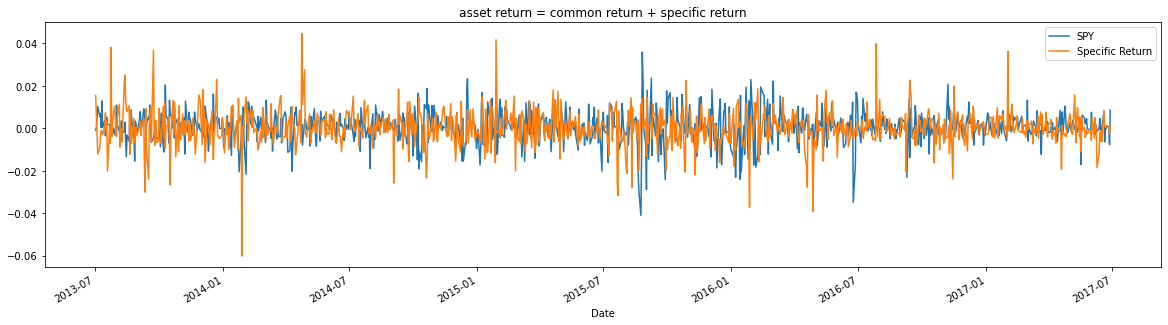

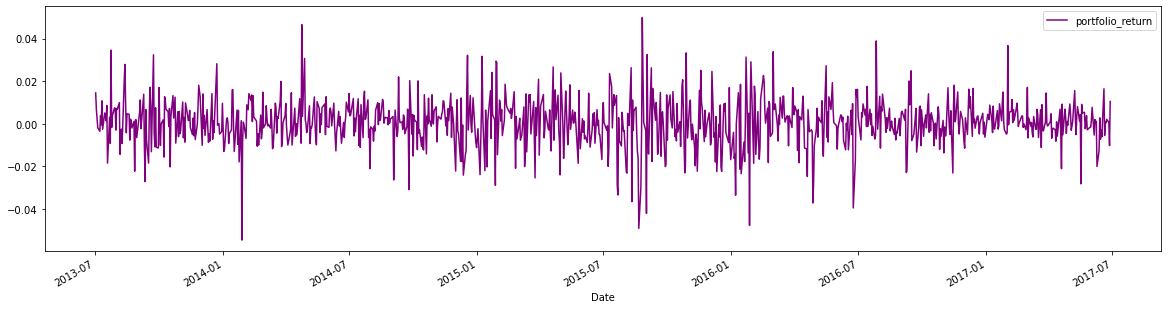

In [75]:
fig = return_components.plot(title="asset return = common return + specific return");
pd.DataFrame(portfolio_return).plot(color='purple');

plt.rcParams["figure.figsize"] = (20,5)
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]